# Creating Ridge Plots from FlowJo exported Flow Cytometry Histograms

In [332]:
# Directory stuff
import os

# Dataframe stuff
import pandas as pd
import numpy as np

# Viz stuff
import seaborn as sns
from matplotlib import pyplot as plt

In [87]:
%matplotlib inline

## Loading Data

1. **ISSUE**: FlowJo does not let you name subpopulations and is absolutely useless in this area.
    1. Workaround: create your own keyword and add the sample name in here. You can choose this keyword when setting file naming patterns.
2. Load all csvs in a directory, use file name to name sample name.
    1. **ISSUE**: Naming files with things like "0.5" breaks file. Tried using "1:2" to represent this idea. Probably want to use "0,5" instead next time because FlowJo output "1:2ul" as "12ul"
3. Convert into tidy format
4. Concatenate together into single experiment dataframe

## Single Sample Loading (Testing)

In [259]:
data = pd.read_csv("/Users/adrian/code/lab/tc_tools/inputs/L16 QKRR 8ul.csv")
data.head(10)

,FITC-A,Time
0,5544.7,0.566551
1,22099.7,0.568646
2,15812.3,0.569693
3,26119.1,0.570740
4,1348.2,0.571788
5,4442.9,0.578071
6,6129.9,0.579118
7,3657.5,0.585402
8,8145.9,0.586449
9,5981.5,0.587496


# Single Histogram plotting (testing)

1. Export Sample > Alive > Singles from FlowJo as **FITC-A vs Time**
2. **DO NOT** export as histogram. Trying to regraph their binned data causes issues.
3. Use log-scale on FITC-A axis and set bins=256

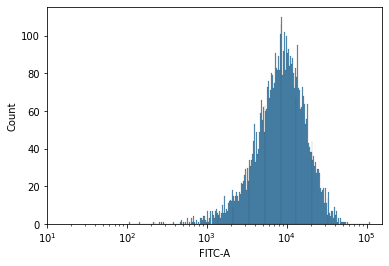

In [181]:
fig,axs = plt.subplots()
sns.histplot(ax=axs,data=g,x="FITC-A",log_scale=True,bins=256)
axs.set_xticks([1e1,1e2,1e3,1e4,1e5])

## Directory Loading

In [333]:
flow_dir = "/Users/Adrian/Documents/research/flow"
export_dir = "exports"

# This is the experiment directory you choose
exp_dir = "2021 12-21 jurkat exp check"
csv_dir= f"{flow_dir}/{exp_dir}/{export_dir}"

In [167]:
# Loads in CSVs and creates Sample column to concatenate CSVs in tidy format
def load_csvs(csv_dir):
    csvs = [f for f in os.listdir(csv_dir) if f.endswith(".csv")]
    
    dfs = []
    for csv in csvs:
        sample_name = csv.split(".")[0]
        df = pd.read_csv(f"{csv_dir}/{csv}")
        rows = df.shape[0]
        df["Sample"] = [sample_name]*rows
        dfs.append(df)
    exp_df = pd.concat(dfs,ignore_index=True)
    return exp_df

In [168]:
exp_df = load_csvs(csv_dir)

In [311]:
exp_df

,FITC-A,Time,Sample
0,20371.4,0.508186,L16 E34
1,17880.8,0.512243,L16 E34
2,5837.3,0.514272,L16 E34
3,27633.2,0.525430,L16 E34
4,16207.1,0.545716,L16 E34
...,...,...,...
143824,10818.5,21.568200,L16 QKRR Hi
143825,8450.4,21.568200,L16 QKRR Hi
143826,3182.2,21.573500,L16 QKRR Hi
143827,3894.1,21.574600,L16 QKRR Hi


## Break down name into descriptive columns

1. Programmatically tokenize sample name into individual columns:
    1. L16 QKRR 8ul --> Lag Binder, CAM name, Virus Concentration
    2. **Issues** we need to adapt this for different situations, can't do it unsupervised (I don't think?)
    3. Standardized naming convention? Just fill in missing data

## Subsetting DF

In [330]:
subset = pd.DataFrame(exp_df)

# NOTE: files couldnt handle 0.5ul so i wrote 1:2 ul but then pandas loaded it as 12ul -___-                
split_df = subset["Sample"].str.split(" ",expand=True)  
subset[["Lag Binder","CAM", "Virus Conc"]] = split_df
subset.head(10)

,FITC-A,Time,Sample,Lag Binder,CAM,Virus Conc
0,20371.4,0.508186,L16 E34,L16,E34,None
1,17880.8,0.512243,L16 E34,L16,E34,None
2,5837.3,0.514272,L16 E34,L16,E34,None
3,27633.2,0.525430,L16 E34,L16,E34,None
4,16207.1,0.545716,L16 E34,L16,E34,None
5,9055.9,0.555860,L16 E34,L16,E34,None
6,20107.5,0.576147,L16 E34,L16,E34,None
7,22719.2,0.581218,L16 E34,L16,E34,None
8,7875.7,0.586290,L16 E34,L16,E34,None
9,40397.0,0.611649,L16 E34,L16,E34,None


# TODO: Groupby Plotting
* Need to create ridgeplots per each groupby
* Might need to move groupby outside
* Need to include control into each groupby

In [492]:
lag16qkrr = subset[subset["Sample"].str.startswith("L16 QKRR")]
lag16qkrr["Sample"].unique()

lag17qkrr = subset[subset["Sample"].str.startswith("L17 QKRR")]
lag17qkrr["Sample"].unique()

lag17icam = subset[subset["Sample"].str.startswith("L17 ICAM")]
lag17icam["Sample"].unique()

lag42icam = subset[subset["Sample"].str.startswith("L42 ICAM")]
lag42icam["Sample"].unique()

array(['L42 ICAM 2ul', 'L42 ICAM 12ul', 'L42 ICAM 1ul'], dtype=object)

In [470]:
lag16qkrr.groupby("Sample").describe()

FITC-A                                                          \
               count          mean           std    min        25%       50%   
Sample                                                                         
L16 QKRR 1ul  3334.0  11458.259898   7351.380053  140.7   6140.400  10063.55   
L16 QKRR 2ul  5796.0  10507.180918   7184.962148  139.3   5360.950   9063.25   
L16 QKRR 4ul  6122.0   8575.718295   6091.392429   83.3   4393.550   7149.45   
L16 QKRR 8ul  5135.0  10475.036417   7190.666654  210.0   5544.700   8735.30   
L16 QKRR Hi   6424.0   8572.890302   6761.078427   -3.5   3666.250   6949.25   
L16 QKRR Lo   5552.0  20678.106664  11196.805891  126.0  12517.575  19512.85   
L16 QKRR Med  6430.0   9851.999984   6712.508821   35.7   5266.100   8441.30   

                                     Time                                  \
                    75%       max   count       mean        std       min   
Sample                                                                      
L16 QKRR 1ul  15194.375   64146.6  3334.0  12.782279   7.298409  0.555084   
L16 QKRR 2ul  13730.500   77702.1  5796.0  12.378171   7.057402  0.571578   
L16 QKRR 4ul  11166.750   63854.0  6122.0   9.329127   5.267667  0.564050   
L16 QKRR 8ul  13585.250  109560.0  5135.0  10.420876   5.987246  0.566551   
L16 QKRR Hi   11701.900   63259.0  6424.0  11.057798   6.156554  0.579945   
L16 QKRR Lo   27515.250   84968.1  5552.0  25.139637  13.650574  0.506656   
L16 QKRR Med  12782.525   75335.4  6430.0   9.921424   5.587338  0.604252   

                                                        
                    25%        50%        75%      max  
Sample                                                  
L16 QKRR 1ul   6.227443  12.933050  19.186750  25.5466  
L16 QKRR 2ul   6.254500  12.082900  18.702175  24.5664  
L16 QKRR 4ul   4.906590   8.906175  13.951875  18.5576  
L16 QKRR 8ul   5.247145  10.048200  15.946150  20.5613  
L16 QKRR Hi    5.817372  10.824750  16.643175  21.5799  
L16 QKRR Lo   13.946625  26.065150  36.008750  50.5067  
L16 QKRR Med   5.214960   9.475920  14.948150  19.6043

## NOTE: Zero Variance populations cause issues with kdeplot

In [469]:
lag17icam.groupby("Sample").describe()

FITC-A                                                          \
                count          mean           std      min       25%      50%   
Sample                                                                          
L17 ICAM 12ul     1.0  51544.500000           NaN  51544.5  51544.50  51544.5   
L17 ICAM 1ul   1013.0  54471.514906  19943.341023     99.4  39825.10  52516.1   
L17 ICAM 2ul   5631.0  24448.344948  11201.078994    552.3  15751.05  24160.5   

                                     Time                                   \
                    75%       max   count       mean        std        min   
Sample                                                                       
L17 ICAM 12ul  51544.50   51544.5     1.0  28.573500        NaN  28.573500   
L17 ICAM 1ul   67276.30  182865.0  1013.0  22.884705  13.847763   0.432189   
L17 ICAM 2ul   31893.05   84715.4  5631.0  21.099010  12.600486   0.499134   

                                                     
                    25%      50%       75%      max  
Sample                                               
L17 ICAM 12ul  28.57350  28.5735  28.57350  28.5735  
L17 ICAM 1ul   11.33020  20.8678  34.17540  50.4322  
L17 ICAM 2ul   10.03175  20.3369  31.32345  45.4991

Sending over: L16 QKRR


/Users/adrian/code/lab/tc_tools/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


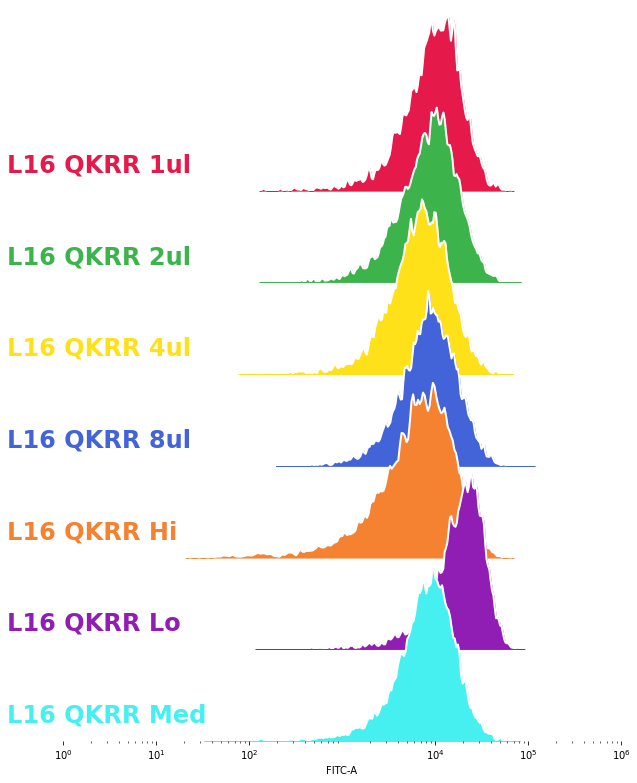

Sending over: L17 ICAM
Error: population did not generate a kde_line


/Users/adrian/code/lab/tc_tools/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


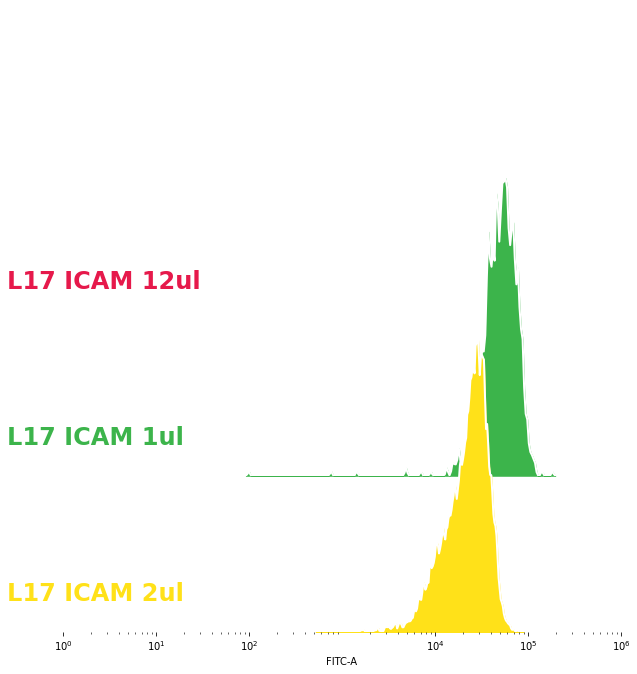

Sending over: L17 QKRR


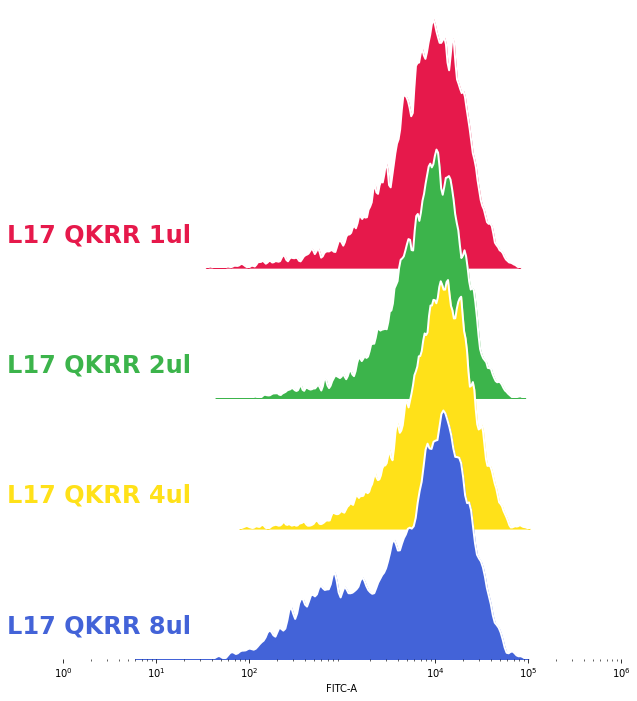

Sending over: L18 ICAM


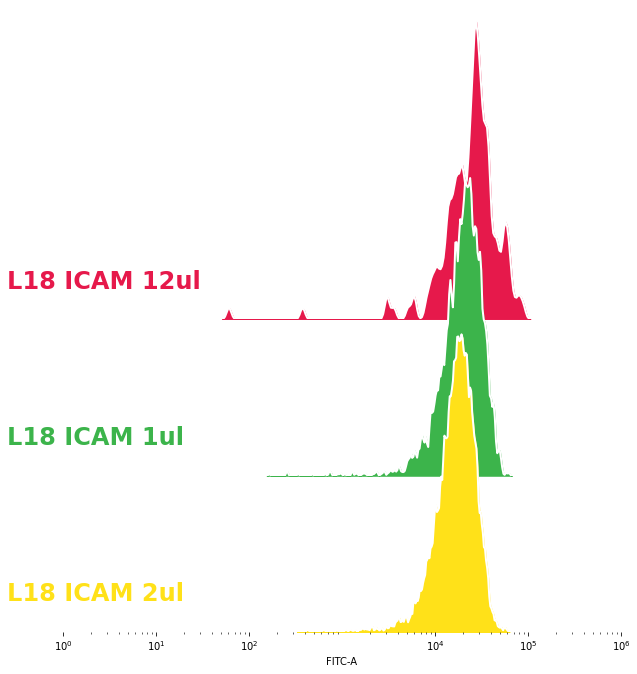

Sending over: L18 QKRR


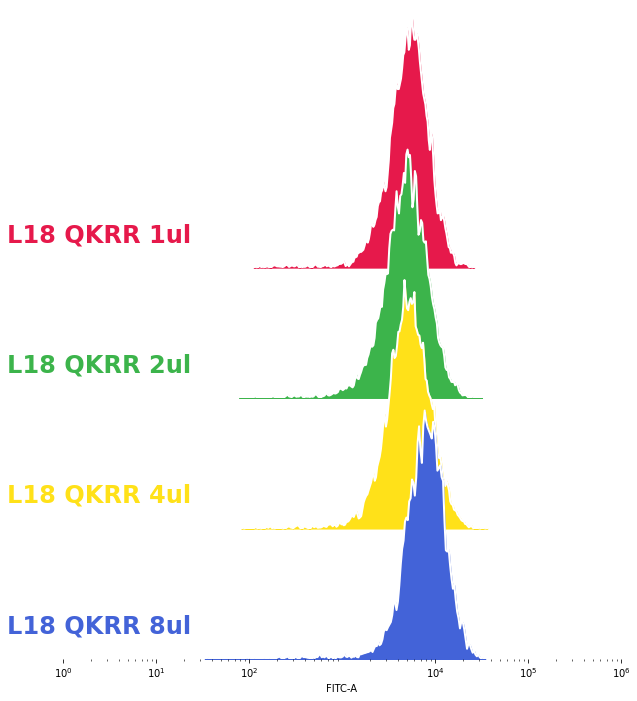

Sending over: L42 ICAM


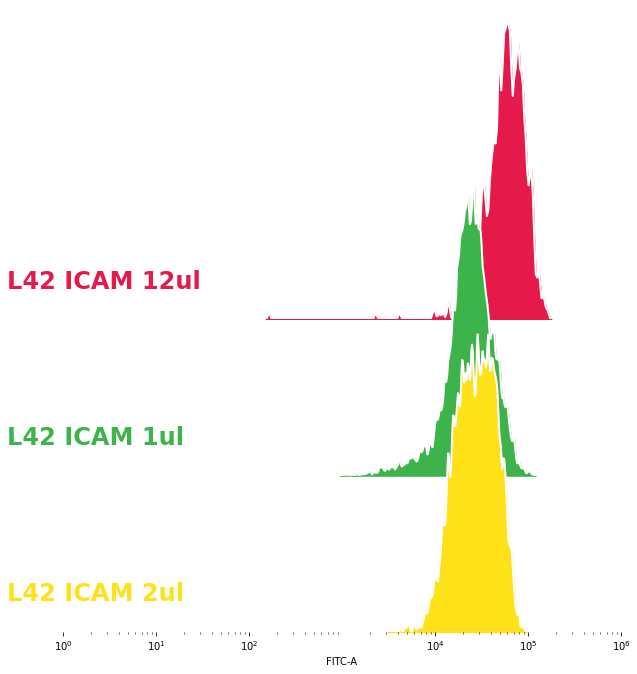

Sending over: L42 QKRR


/Users/adrian/code/lab/tc_tools/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


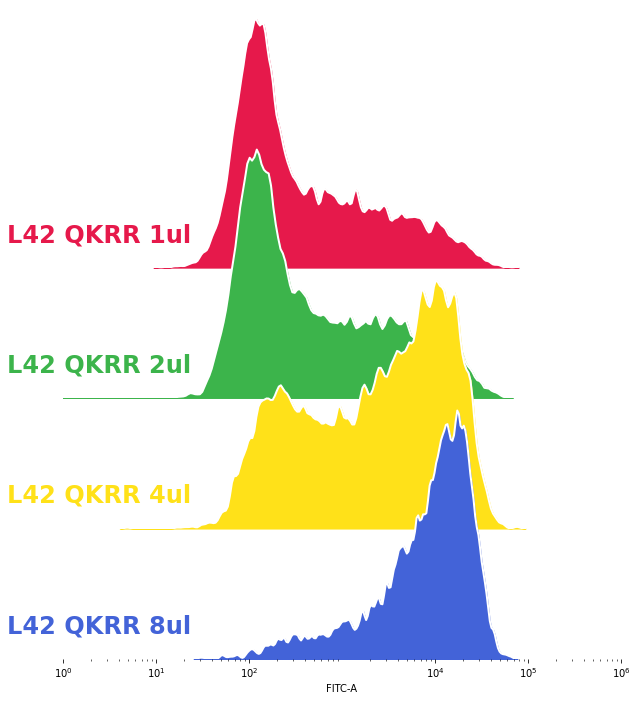

In [496]:
#grouped = subset.groupby(["Lag Binder","CAM","Virus Conc"])
grouped = subset.groupby(["Lag Binder","CAM"])
grouped.describe()

for group in grouped:
    name,df = group
    name = " ".join(name)
    
    # Sending single sample df to ridgeplot breaks it. Handle in/out of function
    if len(df["Virus Conc"].unique()) > 1:
        print(f"Sending over: {name}")
        ridgeplot(df,"Sample")

## New Ridgeplot (WIP)

### TODO:
* Create the histograms individually and store them in a list
* Group these together and graph them.
    * This would separate responsibilities.
* How much does peak height matter?

In [494]:
# NOTE: this currently breaks when only sending in one population to graph into ridgeplot be careful with groupbys
# NOTE: this is also possibly breaking with low event populations...? zero variance populations do not get a kdeplot
# TODO: Generate a placeholder or indicator that population was skipped
def ridgeplot(df,by):
    # TODO: get more colors?
    # List of separable colors
    colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
          '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
    grouped = df.groupby(by)
    num_samples = len(grouped)
    overlap=0.5

    # TODO: figsize scaled by number and spacing of overlap
    # TODO: add a title
    fig,axs = plt.subplots(num_samples,figsize=(10,10+num_samples*overlap))
    for i,sample in enumerate(grouped):
        sample_name, sample_df = sample
        sns.kdeplot(data=sample_df,ax=axs[i],x="FITC-A",log_scale=True,
                   bw_adjust=0.2,color="white",linewidth=2)
        axs[i].set_xticks([1e0,1e1,1e2,1e4,1e5,1e6])
        axs[i].set_xlim([1e0,1e6])

        # Fill under graph with different color
        kde_lines = axs[i].lines
        if len(kde_lines) >0:
            kde_x, kde_y = kde_lines[0].get_data()
            axs[i].fill_between(kde_x,kde_y,color=colors[i])
        else:
            print("Error: population did not generate a kde_line")

        # Set the background transparent
        axs[i].patch.set_alpha(0)

        # Turns off the axes for everything EXCEPT the last one
        if i != num_samples-1:
            axs[i].axis("off")

        # Last axes just disable y label and ticks
        axs[i].set_ylabel("")    
        axs[i].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,
        labelleft=False) # labels along the bottom edge are off

        # Remove all spines    
        spines = ["left","top","right","bottom"]
        for spine in spines:
            axs[i].spines[spine].set_visible(False)

        # Sample labels
        # transform places coords wrt each axes
        axs[i].text(-0.1,0.1,sample_name,fontweight="bold",fontsize=24,color=colors[i],transform=axs[i].transAxes)
        #print(i,colors[i])
    # Overlap subplots
    plt.subplots_adjust(hspace=-overlap)
    plt.show()    
    
    # TODO: return a plot that can be grouped together with other plots? maybe?